# text2poem
Given a list of topics, generate a related poem

## To-do:
- [ ] Tune the batch size
- [ ] Tune the number of epochs

## Install Dependencies

In [1]:
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 5.6MB/s 
     |████████████████████████████████| 901kB 24.0MB/s 
     |████████████████████████████████| 3.3MB 12.3MB/s 
     |████████████████████████████████| 1.1MB 4.3MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [3]:
%reset -f

## Import Libraries

In [4]:
# General libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla K80


## Constants

In [6]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/topics_250_top_authors.csv"
MODEL_NAME = "t5-small"

SEED = 42

# Specified in the number of tokens
MAX_LEN = 512
SUMMARY_LEN = 512

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 10 # 5 is good enough for 5k samples in data
LR = 3e-4

PREFIX = "poemify: " # The T5 prefix to append to the inputs

In [7]:
# Set random seeds and make pytorch deterministic for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

## Helper Functions

In [8]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [9]:
def replaceSep(text, sep = "|"):
    """ Replaces '\n' by sep everywhere, as T5Tokenizer just replaces '\n' by a blank space """
    return text.replace("\n", sep)

In [10]:
def loadDF(path, n_rows = None, prefix = PREFIX):
    """ Loads the CSV data, converts it to the specified format, and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")

    # Drop the NaN rows (if any)
    df.dropna(inplace = True)

    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]

    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)

    # Add a suitable prefix to the text input
    df["input"] = prefix + df["input"]

    # Truncate the dataset if specified
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Replace newlines in the poem
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)
    
    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [11]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders, shuffle = False since we already shuffled once while creating the train-test split
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [12]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

## Train and Validate Functions:

In [13]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
                
        loss_batches.append(loss.item())
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss_batches

In [14]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

In [15]:
def generate(topics):

    input = PREFIX + ", ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        max_length = 1024,
        num_beams = 1,
        # early_stopping = True,
        no_repeat_ngram_size = 2
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [16]:
def genSample(topics, min_length, max_length, rep_penalty, temp = 1):

    input = PREFIX + ", ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        temperature = temp,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

## Main

In [17]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [18]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = PREFIX)
print(len(df), len(df_train), len(df_val))

631 626 5


In [19]:
display(df)

,output,input
0,"Of old sat Freedom on the heights, | The thund...","poemify: triple forks, starry lights, majestic..."
1,"You ask me, why, tho' ill at ease, | Within th...","poemify: golden sand-, seldom gathers, old ren..."
2,Deep on the convent-roof the snows | Are spark...,"poemify: first snowdrop, white robes, creeping..."
3,"Sunset and evening star, | And one clear call ...","poemify: clear call, deep Turns, moving, eveni..."
4,"It is the miller's daughter, | And she is grow...","poemify: balmy bosom, dainty waist, round, jew..."
...,...,...
626,"The world is too much with us; late and soon, ...","poemify: wreathèd horn, sordid boon, old Trito..."
627,Beneath these fruit-tree boughs that shed | Th...,"poemify: thy dominion, sequestered nook, green..."
628,"A poet! | -He hath put his heart to school, | ...","poemify: divine vitality, little flower, own d..."
629,Mother! whose virgin bosom was uncrost | With ...,"poemify: unblemished moon, solitary boast, blu..."


In [20]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

313 3


### Loading the Model

In [21]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [22]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 60,506,624 trainable and 0 frozen parameters


### Optimization

In [23]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [24]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}")
    loss_batches = train(e, tokenizer, model, dl_train, optimizer)
    losses += loss_batches

Epoch 1


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10


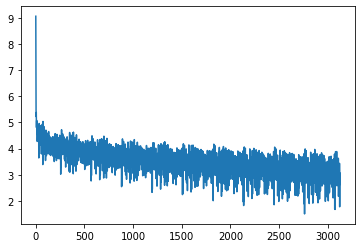

In [25]:
plt.plot(range(len(losses)), losses)
plt.show()

In [26]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [27]:
display(results)

,Generated Text,Actual Text
0,Is it possible to see the world? | Where indiv...,"Come, I will make the continent indissoluble, ..."
1,"I slept in the morning, | And sleep was not so...",My spirit is too weak-mortality | Weighs heavi...
2,"I sat in the sky, and watched my night. | And ...","Aspasie, trillistos. | I heard the trailing ga..."
3,"Thine love, thy dear |pity that I have loved;-...","If thou must love me, let it be for nought | E..."
4,The starlit Stonehenge | And neighbour Parson ...,"That night your great guns, unawares, | Shook ..."


In [ ]:
x = 0
print(results.iloc[x]["Generated Text"], "\n")
print(results.iloc[x]["Actual Text"])

In [29]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.3, 0.9)

The wind comes down, and the weeping is gone.

The rustling has been in its forest;
And the dusolate is gone;
But what is that quivering?
I shall come back to return again.
I can not see where it stands:
My tree of our warfarers is going northward,
For I must keep the sun still on my side.
O how long will it last for me?
A villager who like this would be going wildbound,
That seems to have heard these things before:
We do take some time because they are coming out after you die!


In [30]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.4, 0.7)

Upon the brink of the wind, I shall be in it again.
But when we are weeping on the tree's side or by side,
We will grow and dry up the branches to cloud;
For that is why I am having no effect:
The winds overtake us for you!
And then werep from there out-of-town,
Which means our forests should not see.
In forest with gust but desolate they form
A bit more like piney trees queering
To me she goes down my path towards victory.


In [31]:
gen = genSample(["happy", "elated smile", "good luck", "beautiful eyes"], 100, 500, 1.3, 0.9)

The smile was happy,
And I have not had an elated smile.
But now we keep on smiling;
We are happy with our eyes:
It is no more than bright again!
A man who loves me very much,
You are the one who has good luck at first:
That what makes us happy?
What does you do to get away?
Let us take this picture through and through;
With beautiful eyes there seems to be great


In [32]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.5, 0.9)

There's no joyous sun,
And here you are not alone in the dance trees.
The glowing sun is filled with laughter and elated smile as well!
How happy will I see from my teeth?
O yes! What happiness does all seem like an angel;
A joyful face that can be found on your forehead:
With love for any singing tree-
Can we please me when paths grow or vanish of life. • But what joyously deserves to meet these days?


In [33]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.4)

There is an elated smile in the stars:
The dancing trees hold joyous as well;
It greets us when we feel like you are angry,
And I think that will make me happy more. But these days our smiling faces take on
The glow of those eyes:-
That means too light to go!
Yes bright and cheerful
A joyful face has hither with ease;
When your dreams come down...
We have fallen asleep by the dawn hours after midnight.


In [34]:
gen = genSample(["hoary sky", "consistent light", "long time", "taking", "silly" ,"back", "animals", "tired"], 100, 500, 1.4, 0.8)

I remember not a long time,
But what is going on?
And then that was so sad:
Now we are tired and silly.

My animal's back for me
We want to see the hoary sky;
It has been such a shining light;
That it takes in people who take us too soon!
The animals return from our shoulders.

You can say no more than your head (or you may be ashamed)
No longer being old enough to know
Which they do need to know how good this young boy took at all.


## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```